# exp010 結果分析

**目的**: exp010の実験結果を分析し、次回実験に向けた知見を整理

**内容**:
1. 実験サマリー（CV MAPE 12.19%）
2. 特徴量重要度分析
3. エラー分析（価格帯別・セグメント別）
4. 削除対象特徴量（35個）
5. 次回に向けた整理

## セットアップ

In [1]:
import sys
from pathlib import Path
import os

# プロジェクトルート設定
project_root = Path().resolve().parent.parent.parent
sys.path.insert(0, str(project_root / "04_src"))
sys.path.insert(0, str(project_root / "06_experiments/exp010_low_price_improvement/code"))
os.chdir(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import json

# 表示設定
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 6)

print(f"プロジェクトルート: {project_root}")

プロジェクトルート: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


In [2]:
# 実験結果読み込み
EXP_DIR = Path("06_experiments/exp010_low_price_improvement")
OUTPUT_DIR = EXP_DIR / "outputs/run_20251128_090118"

# OOF予測
oof = pd.read_csv(OUTPUT_DIR / "oof_predictions.csv")

# 特徴量重要度
with open(OUTPUT_DIR / "feature_importance.json") as f:
    fi_raw = json.load(f)
fi = dict(zip(fi_raw['feature'], fi_raw['importance']))

print(f"OOFレコード数: {len(oof):,}")
print(f"特徴量数: {len(fi)}")

OOFレコード数: 363,924
特徴量数: 262


## 1. 実験サマリー

In [3]:
# 全体MAPE
oof['ape'] = np.abs(oof['actual'] - oof['predicted']) / oof['actual'] * 100
overall_mape = oof['ape'].mean()

print("="*50)
print("exp010 実験結果サマリー")
print("="*50)
print(f"CV MAPE: {overall_mape:.2f}%")
print(f"使用特徴量: {len(fi)}個")
print(f"\n比較:")
print(f"  exp009: 12.48%")
print(f"  exp010: {overall_mape:.2f}%")
print(f"  改善: {12.48 - overall_mape:.2f}ポイント")
print(f"\n特徴量選択:")
print(f"  削除対象: 35個（TF-IDF 20 + カウント系 12 + その他 3）")
print(f"  → exp011以降で227特徴量で学習")

exp010 実験結果サマリー
CV MAPE: 12.19%
使用特徴量: 262個

比較:
  exp009: 12.48%
  exp010: 12.19%
  改善: 0.29ポイント

特徴量選択:
  削除対象: 35個（TF-IDF 20 + カウント系 12 + その他 3）
  → exp011以降で227特徴量で学習


## 2. 特徴量重要度分析

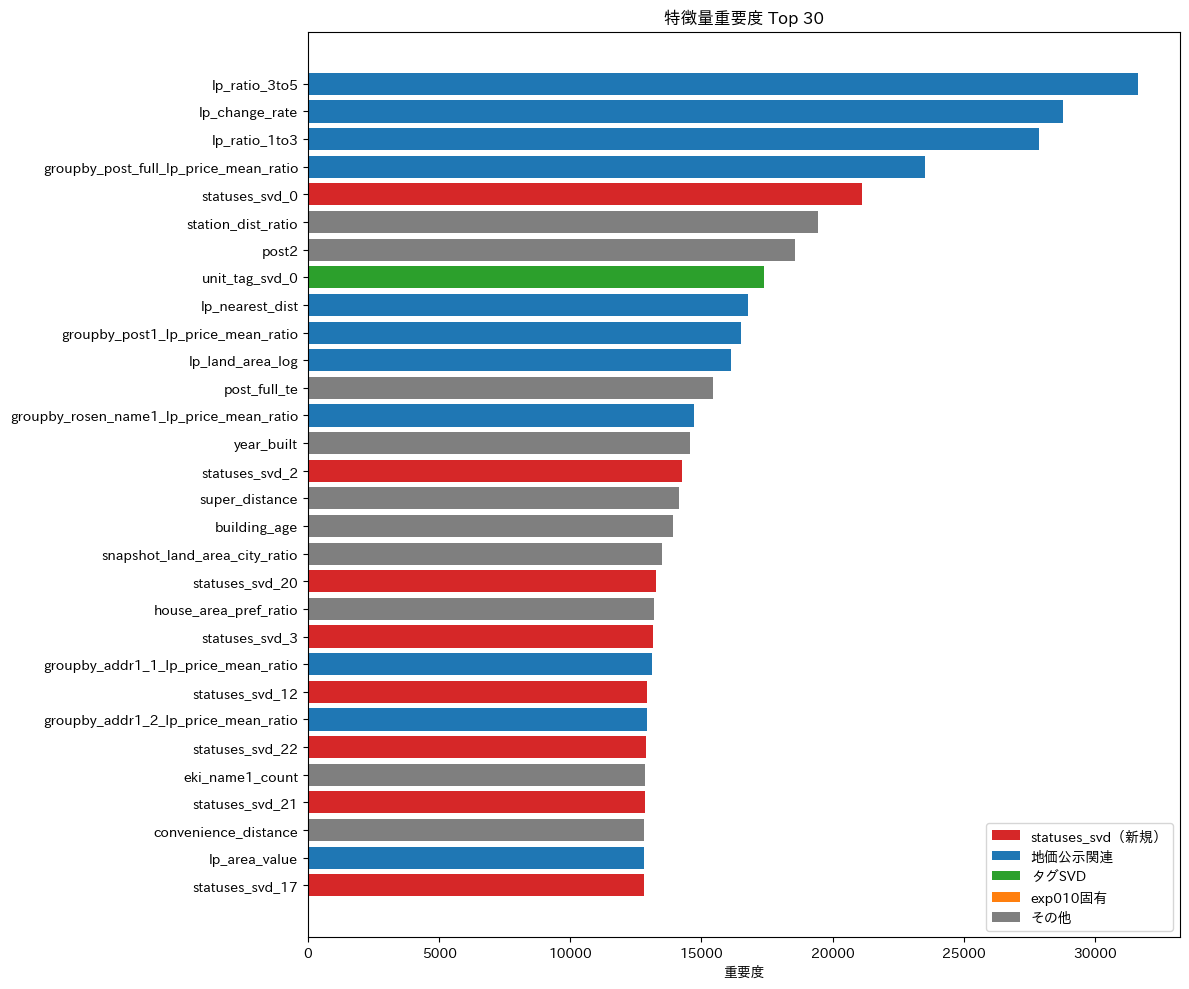

In [4]:
# Top 30 重要度
fi_sorted = sorted(fi.items(), key=lambda x: x[1], reverse=True)
top_30 = fi_sorted[:30]

fig, ax = plt.subplots(figsize=(12, 10))
names = [x[0] for x in top_30][::-1]
values = [x[1] for x in top_30][::-1]

# 色分け（カテゴリ別）
colors = []
for name in names:
    if 'statuses' in name:
        colors.append('tab:red')
    elif 'lp_' in name or 'groupby' in name:
        colors.append('tab:blue')
    elif 'tag_svd' in name:
        colors.append('tab:green')
    elif name in ['lp_area_value', 'area_age_category', 'area_age_cat_te_addr1_1', 'area_age_cat_te_land_youto']:
        colors.append('tab:orange')
    else:
        colors.append('tab:gray')

ax.barh(names, values, color=colors)
ax.set_xlabel('重要度')
ax.set_title('特徴量重要度 Top 30')

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='tab:red', label='statuses_svd（新規）'),
    Patch(facecolor='tab:blue', label='地価公示関連'),
    Patch(facecolor='tab:green', label='タグSVD'),
    Patch(facecolor='tab:orange', label='exp010固有'),
    Patch(facecolor='tab:gray', label='その他'),
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

In [5]:
# カテゴリ別重要度合計
categories = {
    'statuses_svd': [k for k in fi.keys() if 'statuses' in k],
    'unit_tag_svd': [k for k in fi.keys() if 'unit_tag' in k],
    'building_tag_svd': [k for k in fi.keys() if 'building_tag' in k],
    'lp_groupby': [k for k in fi.keys() if 'groupby' in k],
    'lp_direct': [k for k in fi.keys() if k.startswith('lp_') and 'groupby' not in k],
    'tfidf': [k for k in fi.keys() if 'tfidf' in k],
    'reform_svd': [k for k in fi.keys() if 'reform' in k],
    'exp010固有': ['lp_area_value', 'area_age_category', 'area_age_cat_te_addr1_1', 'area_age_cat_te_land_youto'],
}

cat_importance = {}
for cat, features in categories.items():
    total = sum(fi.get(f, 0) for f in features)
    cat_importance[cat] = total

cat_df = pd.DataFrame([
    {'カテゴリ': k, '重要度合計': v, '特徴量数': len(categories[k])}
    for k, v in sorted(cat_importance.items(), key=lambda x: x[1], reverse=True)
])
cat_df['平均重要度'] = cat_df['重要度合計'] / cat_df['特徴量数']
cat_df

,カテゴリ,重要度合計,特徴量数,平均重要度
0,statuses_svd,386660.000000,30,12888.666667
1,unit_tag_svd,289312.666667,30,9643.755556
2,lp_direct,235803.000000,25,9432.120000
3,lp_groupby,155736.666667,18,8652.037037
4,building_tag_svd,103338.666667,15,6889.244444
5,exp010固有,27475.666667,4,6868.916667
6,reform_svd,15589.333333,9,1732.148148
7,tfidf,2937.666667,20,146.883333


In [6]:
# statuses_svd の詳細
statuses_fi = [(k, v) for k, v in fi.items() if 'statuses' in k]
statuses_fi.sort(key=lambda x: x[1], reverse=True)

print("=== statuses_svd 重要度 ===")
print(f"合計: {sum(v for _, v in statuses_fi):,.0f}")
print(f"\nTop 10:")
for name, imp in statuses_fi[:10]:
    print(f"  {name}: {imp:,.0f}")

=== statuses_svd 重要度 ===
合計: 386,660

Top 10:
  statuses_svd_0: 21,133
  statuses_svd_2: 14,278
  statuses_svd_20: 13,254
  statuses_svd_3: 13,134
  statuses_svd_12: 12,929
  statuses_svd_22: 12,899
  statuses_svd_21: 12,841
  statuses_svd_17: 12,800
  statuses_svd_1: 12,766
  statuses_svd_19: 12,715


## 3. エラー分析

In [7]:
# 価格帯別MAPE
oof['price_bin'] = pd.cut(
    oof['actual'],
    bins=[0, 10_000_000, 30_000_000, 50_000_000, 100_000_000, float('inf')],
    labels=['~1000万', '1000~3000万', '3000~5000万', '5000万~1億', '1億~']
)

price_mape = oof.groupby('price_bin', observed=True).agg(
    件数=('ape', 'count'),
    MAPE=('ape', 'mean'),
    MAPE_std=('ape', 'std'),
    中央値APE=('ape', 'median'),
).round(2)

price_mape['割合'] = (price_mape['件数'] / len(oof) * 100).round(1)
price_mape

,件数,MAPE,MAPE_std,中央値APE,割合
price_bin,,,,,
~1000万,49307,19.99,25.91,11.61,13.5
1000~3000万,213736,11.51,11.91,8.28,58.7
3000~5000万,74894,9.38,9.17,6.93,20.6
5000万~1億,22666,10.63,10.25,7.73,6.2
1億~,3321,14.05,13.57,10.20,0.9


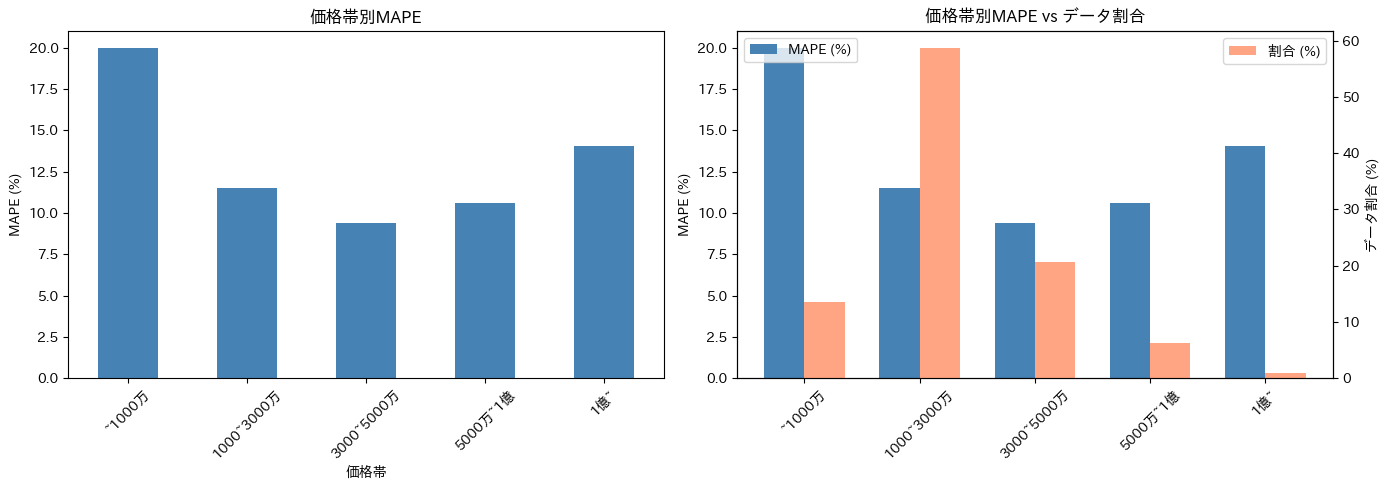

In [8]:
# 価格帯別MAPE可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 棒グラフ
ax1 = axes[0]
price_mape['MAPE'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_ylabel('MAPE (%)')
ax1.set_xlabel('価格帯')
ax1.set_title('価格帯別MAPE')
ax1.tick_params(axis='x', rotation=45)

# 件数との比較
ax2 = axes[1]
x = range(len(price_mape))
width = 0.35
ax2.bar([i - width/2 for i in x], price_mape['MAPE'], width, label='MAPE (%)', color='steelblue')
ax2_twin = ax2.twinx()
ax2_twin.bar([i + width/2 for i in x], price_mape['割合'], width, label='割合 (%)', color='coral', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(price_mape.index, rotation=45)
ax2.set_ylabel('MAPE (%)')
ax2_twin.set_ylabel('データ割合 (%)')
ax2.set_title('価格帯別MAPE vs データ割合')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

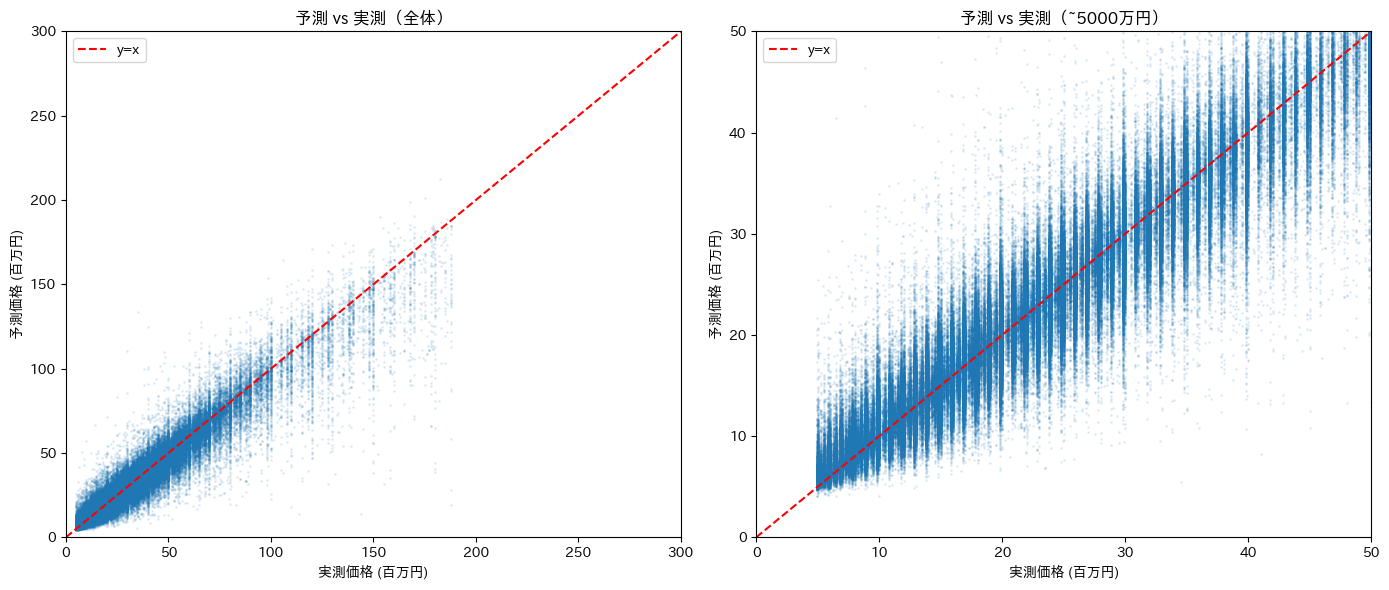

In [9]:
# 予測値 vs 実測値 散布図
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 全体
ax1 = axes[0]
ax1.scatter(oof['actual'] / 1e6, oof['predicted'] / 1e6, alpha=0.1, s=1)
ax1.plot([0, 300], [0, 300], 'r--', label='y=x')
ax1.set_xlabel('実測価格 (百万円)')
ax1.set_ylabel('予測価格 (百万円)')
ax1.set_title('予測 vs 実測（全体）')
ax1.set_xlim(0, 300)
ax1.set_ylim(0, 300)
ax1.legend()

# 低価格帯ズーム
ax2 = axes[1]
low_price = oof[oof['actual'] <= 50_000_000]
ax2.scatter(low_price['actual'] / 1e6, low_price['predicted'] / 1e6, alpha=0.1, s=1)
ax2.plot([0, 50], [0, 50], 'r--', label='y=x')
ax2.set_xlabel('実測価格 (百万円)')
ax2.set_ylabel('予測価格 (百万円)')
ax2.set_title('予測 vs 実測（~5000万円）')
ax2.set_xlim(0, 50)
ax2.set_ylim(0, 50)
ax2.legend()

plt.tight_layout()
plt.show()

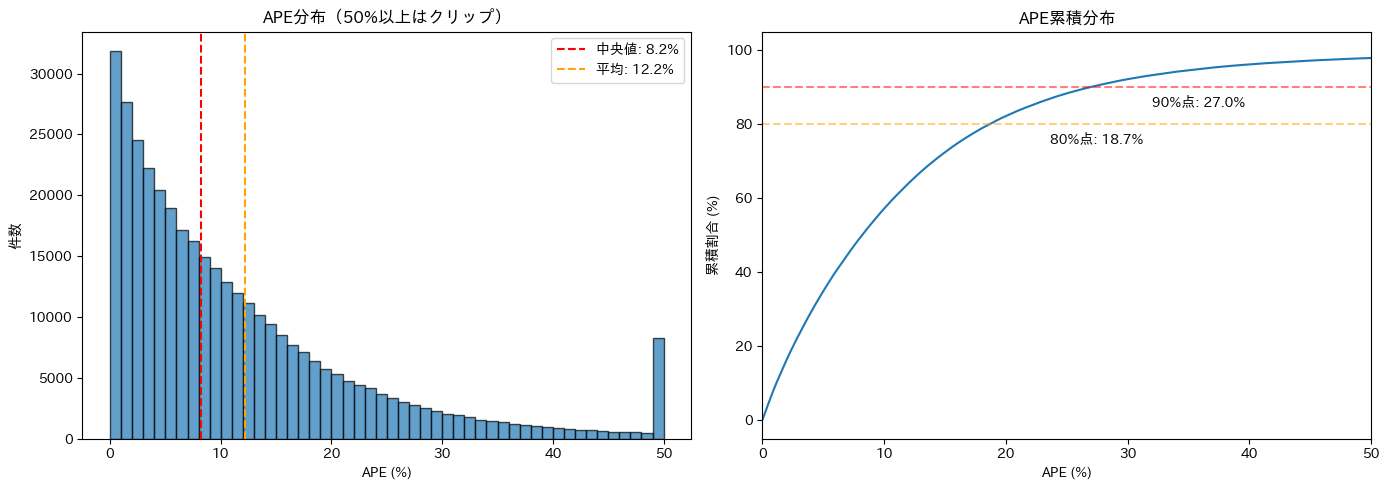

In [10]:
# APE分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ヒストグラム
ax1 = axes[0]
ax1.hist(oof['ape'].clip(upper=50), bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(oof['ape'].median(), color='red', linestyle='--', label=f'中央値: {oof["ape"].median():.1f}%')
ax1.axvline(oof['ape'].mean(), color='orange', linestyle='--', label=f'平均: {oof["ape"].mean():.1f}%')
ax1.set_xlabel('APE (%)')
ax1.set_ylabel('件数')
ax1.set_title('APE分布（50%以上はクリップ）')
ax1.legend()

# 累積分布
ax2 = axes[1]
sorted_ape = np.sort(oof['ape'])
cumulative = np.arange(1, len(sorted_ape) + 1) / len(sorted_ape) * 100
ax2.plot(sorted_ape, cumulative)
ax2.axhline(90, color='red', linestyle='--', alpha=0.5)
ax2.axhline(80, color='orange', linestyle='--', alpha=0.5)
ax2.set_xlim(0, 50)
ax2.set_xlabel('APE (%)')
ax2.set_ylabel('累積割合 (%)')
ax2.set_title('APE累積分布')

# 80%, 90%点を表示
p80 = np.percentile(oof['ape'], 80)
p90 = np.percentile(oof['ape'], 90)
ax2.annotate(f'80%点: {p80:.1f}%', xy=(p80, 80), xytext=(p80+5, 75))
ax2.annotate(f'90%点: {p90:.1f}%', xy=(p90, 90), xytext=(p90+5, 85))

plt.tight_layout()
plt.show()

In [11]:
# 大きな誤差のサンプル分析
high_error = oof[oof['ape'] > 50].copy()
print(f"APE > 50% のサンプル数: {len(high_error):,} ({len(high_error)/len(oof)*100:.1f}%)")

# 価格帯別
print("\n価格帯別分布:")
print(high_error['price_bin'].value_counts())

APE > 50% のサンプル数: 7,840 (2.2%)

価格帯別分布:
price_bin
~1000万        4653
1000~3000万    2551
3000~5000万     361
5000万~1億       188
1億~             87
Name: count, dtype: int64


## 4. 削除した特徴量一覧

In [12]:
# constants.pyで定義したREMOVE_FEATURESを表示
from constants import REMOVE_FEATURES

print(f"削除特徴量数: {len(REMOVE_FEATURES)}")
print("\n=== 削除特徴量一覧 ===")

# カテゴリ別に分類
tfidf_removed = [f for f in REMOVE_FEATURES if 'tfidf' in f]
count_removed = [f for f in REMOVE_FEATURES if '_count' in f]
other_removed = [f for f in REMOVE_FEATURES if 'tfidf' not in f and '_count' not in f]

print(f"\n【TF-IDF（{len(tfidf_removed)}個）】")
print(f"  {', '.join(tfidf_removed[:5])}...")

print(f"\n【カウント系（{len(count_removed)}個）】")
for f in count_removed:
    print(f"  - {f}")

print(f"\n【その他（{len(other_removed)}個）】")
for f in other_removed:
    print(f"  - {f}")

削除特徴量数: 35

=== 削除特徴量一覧 ===

【TF-IDF（20個）】
  tfidf_0, tfidf_1, tfidf_2, tfidf_3, tfidf_4...

【カウント系（13個）】
  - basement_floor_count
  - building_land_chimoku_count
  - building_status_count
  - building_structure_count
  - building_type_count
  - bukken_type_count
  - flg_investment_count
  - flg_new_count
  - land_chisei_count
  - land_toshi_count
  - management_form_count
  - parking_kubun_count
  - usable_status_count

【その他（2個）】
  - lp_current_use_le
  - groupby_bukken_type_lp_price_mean


In [13]:
# 残り特徴量の重要度分布
print(f"\n=== 残り{len(fi)}特徴量の重要度分布 ===")
fi_values = list(fi.values())
print(f"最大: {max(fi_values):,.0f}")
print(f"最小: {min(fi_values):,.0f}")
print(f"平均: {np.mean(fi_values):,.0f}")
print(f"中央値: {np.median(fi_values):,.0f}")


=== 残り262特徴量の重要度分布 ===
最大: 31,667
最小: 0
平均: 7,161
中央値: 6,853


## 5. 次回に向けた整理

### 5.1 exp010の成果

| 項目 | 結果 |
|------|------|
| CV MAPE | 12.19%（exp009: 12.48%から0.29ポイント改善） |
| 特徴量選択 | 262 → 227（35削除、精度維持確認済み） |
| statuses_svd | 重要度Top（大きな貢献） |
| TF-IDF/カウント系 | 削除（重要度0〜低） |

### 5.2 課題

1. **低価格帯（~1000万）**: MAPEが依然として高い（19.99%）
2. **高価格帯（1億~）**: データ数が少なく不安定
3. **外れ値**: APE > 50% のサンプルが2.2%存在

### 5.3 次回実験（exp011）

**損失関数の改善**
- サンプル重み付け（低価格帯を重視）
- Focal Loss / Huber Loss

In [14]:
print("=" * 60)
print("分析完了")
print("=" * 60)

分析完了
